# Sementaic segmentation
- 이미지에서 도로를 segmentation하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
import os.path as osp
import PIL




- Training data

![source](./data/Kitti/data_road/training/image_2/um_000081.png "Variable")  
./data/Kitti/data_road/training/image_2/um_000081.png (source)

![target](./data/Kitti/data_road/training/gt_image_2/um_road_000081.png "Variable")  
./data/Kitti/data_road/training/gt_image_2/um_road_000081.png (target)


# Dataloader

- 데이터셋 목록 확인하기

In [2]:
# check list of train data
imgsets_file = osp.join('data/Kitti', 'train.txt')

for i, src_tar_name in enumerate(open(imgsets_file)):
    src_tar_name = src_tar_name.split()
    print('%d :' % i, src_tar_name)
    if i > 3:
        break


0 : ['training/image_2/um_000000.png', 'training/gt_image_2/um_road_000000.png']
1 : ['training/image_2/um_000001.png', 'training/gt_image_2/um_road_000001.png']
2 : ['training/image_2/um_000002.png', 'training/gt_image_2/um_road_000002.png']
3 : ['training/image_2/um_000003.png', 'training/gt_image_2/um_road_000003.png']
4 : ['training/image_2/um_000004.png', 'training/gt_image_2/um_road_000004.png']


- 데이터 셋 클래스

In [3]:
class KITTIdataset(torch.utils.data.Dataset):
    class_names = np.array(['background', 'road'])
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    # root <- "./resources"
    def __init__(self, root, split='train', transform=False):
        self._transform = transform
        dataset_dir = osp.join(root, 'Kitti')
        self.files = [] 

        # file names in 'self.files'
        # dict -> self.files.append({"img" : src_tar_name[0], "lbl" : src_tar_name[1] })
        imgsets_file = os.path.join(dataset_dir, '%s.txt'% split)
        for i, src_tar_name in enumerate(open(imgsets_file)):
            src_tar_name = src_tar_name.strip()
            src_tar_name = src_tar_name.split()
            self.files.append({"img" : os.path.join(dataset_dir, "data_road", src_tar_name[0]), "lbl" : os.path.join(dataset_dir, "data_road",src_tar_name[1]) })
        
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        # load image & label
        # TODO
        # image -> img, label -> lbl
        data_file = ...
        img_file = ...
        lbl_file = ...
        
        
        img = PIL.Image.open(img_file)
        img = np.array(img, dtype=np.uint8)
        lbl = PIL.Image.open(lbl_file)
        lbl = np.array(lbl, dtype=np.int32)
        lbl[lbl == 255] = 1
        
        img, lbl = self.transform(img, lbl)
        return img, lbl

    def transform(self, img, lbl):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1) # H W C -> C H W
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl

In [4]:
train_loader = torch.utils.data.DataLoader(KITTIdataset(root = './data', split = 'train', transform = True), 
                                           batch_size = 1, shuffle = True)

val_loader = torch.utils.data.DataLoader(KITTIdataset(root = './data', split = 'val', transform = True), 
                                         batch_size = 1, shuffle = False)

vgg16 = torchvision.models.vgg16(pretrained = True)

# Define the Network

- FCN model

<img src="resources/fcn_upsampling.png" width="60%">

In [5]:
class FCN(nn.Module):
    def __init__(self, num_class = 21):
        super(FCN, self).__init__()
        
        ## Why padding 100?? https://github.com/shelhamer/fcn.berkeleyvision.org
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 100),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(inplace = True))
    
        self.features2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ReLU(inplace = True))
        
        self.features3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1))
        
        self.features4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1))
                
        self.features5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1))
        
        self.maxpool = nn.MaxPool2d(2, stride = 2, ceil_mode = True)

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace = True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace = True),
            nn.Dropout2d(),
            nn.Conv2d(4096, num_class, 1))
        
        self.upscore2 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore4 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore8 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 16, stride = 8, bias = False)
        
        self.score_pool4 = nn.Conv2d(512, num_class, 1)
        self.score_pool3 = nn.Conv2d(256, num_class, 1)
        
        self.params = [self.features1, self.features2, self.features3, 
                       self.features4, self.features5]
        
    def upsample(self, x, size):
        return nn.functional.upsample(x, size = size, mode = 'bilinear')
                             
    def forward(self, inputs):
        x = self.features1(inputs)
        pool1 = self.maxpool(x)
        x = self.features2(pool1)
        pool2 = self.maxpool(x)
        x = self.features3(pool2)
        pool3 = self.maxpool(x)
        x = self.features4(pool3)
        pool4 = self.maxpool(x)
        x = self.features5(pool4)
        pool5 = self.maxpool(x)
        x = self.classifier(pool5)
        
        # also use getattr with for loop ...
        x = self.upscore2(x)
        
        pool4 = self.score_pool4(pool4)
        pool4 = pool4[:, :, 5:5 + x.size()[2], 5:5 + x.size()[3]]
        x = torch.add(x, pool4)
        
        x = self.upscore4(x)
        
        pool3 = self.score_pool3(pool3)
        pool3 = pool3[:, :, 9:9 + x.size()[2], 9:9 + x.size()[3]]
        x = torch.add(x, pool3)
        
        x = self.upscore8(x)
        x = x[:, :, 33:33 + inputs.size()[2], 33:33 + inputs.size()[3]]
        return x
    
    def copy_params(self, vgg):
        for l1, l2 in zip(vgg.features, self.params):
            if (isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d)):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data

# U-Net


-  U-Net model  
![unet](./resources/unet.png "Variable")

- EncoderBlock
    
    - conv2d in -> out (kernel = 3)
    - batchnorm2d
    - relu
    - conv2d out -> out (kernel = 3
    - batchnorm2d
    - relu
    - dropout
    - maxpool (kernel = 2, sride = 2)


- DecoderBlock
    
    - conv2d in -> middle (kernel = 3)
    - batchnorm2d
    - relu
    - conv2d middle -> middle (kernel = 3)
    - batchnorm2d
    - relu
    - convtranspose2d middle -> out (kernel = 3, stride = 2) 

In [6]:

class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        # TODO
        layers = [
            ...
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        # TODO
        self.decode = nn.Sequential(
            ...
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        return F.upsample(final, x.size()[2:], mode='bilinear')

## Measure accuracy and visualization

In [7]:
from PIL import Image # import 
def visualization(net, image, epoch, device):
    net.to('cpu')
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    img = image
    img = np.array(img, dtype = np.uint8)
    img = img[:, :, ::-1] # channel RGB -> BGR
    img = img.astype(np.float64)
    img -= mean_bgr
    img = img.transpose(2, 0, 1) # H W C -> C H W
    img = torch.from_numpy(img).float()
    img = img.unsqueeze(0)

    score = net(img)
    lbl_pred = score.data.max(1)[1].cpu().numpy()
    lbl_pred = np.squeeze(lbl_pred)

    Image.fromarray((lbl_pred * 255).astype(np.uint8)).save('./output/mask_'+str(epoch+1)+'.png')
    
    input_img = image
    input_img = np.array(input_img, dtype = np.uint8)
    color = [0, 255, 0, 127] 
    color = np.array(color).reshape(1, 4)
    shape = input_img.shape
    segmentation = lbl_pred.reshape(shape[0], shape[1], 1)
    output = np.dot(segmentation, color)

    output = Image.fromarray(output.astype(np.uint8))
    background = Image.fromarray(input_img.astype(np.uint8))
    background.paste(output, box = None, mask = output)
    background.save('./output/overlay_'+str(epoch+1)+'.png')

    net.to(device)
    

# Train

In [8]:
import torch.optim as optim

model_type = 'unet'

if model_type == 'unet':
    net = UNet(2)
elif model_type == 'FCN':
    net = FCN(num_class = 2)
    vgg16 = torchvision.models.vgg16(pretrained = True)
    net.copy_params(vgg16)
    del vgg16

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

training_epochs = 5 

# TODO
# criterion : Cross entropy loss
# optimizer : Adam, learning weight=0.003
criterion = ...
optimizer = ...

num_class = 2

for epoch in range(training_epochs):
    print ('current epoch : %d'%(epoch))
    # training
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # TODO
        # data to gpu
        
        # forward
        
        # loss = ...
        
        # update
        
        if batch_idx % 20 ==0:
            print ('batch : %d, loss : %f'%(batch_idx, loss.item()))
        
    #validation
    net.eval()
    
    val_loss = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        # TODO
        # load data
        ...
        # forward
        ...
        
        loss = 
        val_loss += ...
            
    val_loss /= len(val_loader)
    print ('val loss : %f'%val_loss)
        
    #visualization
    img = PIL.Image.open('./data/Kitti/data_road/testing/image_2/um_000081.png')
    visualization(net, img, epoch, device)
    
        
print('Finished Training')

C:\Users\owner\Miniconda3\envs\cv_course\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


current epoch : 0


C:\Users\owner\Miniconda3\envs\cv_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\owner\Miniconda3\envs\cv_course\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\owner\Miniconda3\envs\cv_course\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for detail

batch : 0, loss : 286652.187500
batch : 20, loss : 169800.156250
batch : 40, loss : 202979.593750
batch : 60, loss : 160541.421875
batch : 80, loss : 138307.718750
batch : 100, loss : 121110.671875
batch : 120, loss : 169259.203125
batch : 140, loss : 119615.601562
batch : 160, loss : 77079.210938
batch : 180, loss : 93535.265625
batch : 200, loss : 74679.453125
batch : 220, loss : 219820.875000
batch : 240, loss : 75279.632812
val loss : 121475.282308
current epoch : 1
batch : 0, loss : 75660.429688
batch : 20, loss : 58030.585938
batch : 40, loss : 80913.078125
batch : 60, loss : 68327.609375
batch : 80, loss : 153591.296875
batch : 100, loss : 102932.046875
batch : 120, loss : 52808.046875
batch : 140, loss : 42461.593750
batch : 160, loss : 61073.781250
batch : 180, loss : 44017.851562
batch : 200, loss : 38298.187500
batch : 220, loss : 61594.429688
batch : 240, loss : 52001.117188
val loss : 81998.816243
current epoch : 2
batch : 0, loss : 64460.421875
batch : 20, loss : 40517.15

# Output

'output' 폴더에서 결과 확인

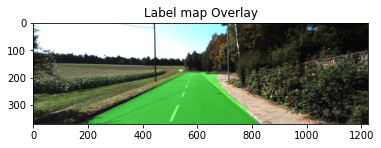

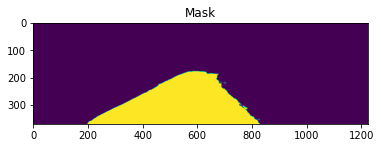

In [9]:
from matplotlib import pyplot as plt 


# show image using matplotlib

img = PIL.Image.open('./output/overlay_1.png')
mask = PIL.Image.open('./output/mask_1.png')
plt.imshow(img), plt.title('Label map Overlay');
plt.figure(), plt.imshow(mask), plt.title('Mask');